In [105]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [106]:
pip install py7zr

Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import gdown
import py7zr
from pathlib import Path
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import warnings

# ignores all future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

In [108]:
# Data import
person = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/person.csv")
appliances = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/appliance.csv")
other_appliances = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/other_appliance.csv")
home = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/home.csv")
survey = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/survey_data/survey_responses.csv")

In [110]:
def load_processed_data():
    """Load preprocessed sensor data with fallback to Drive download"""
    file_id = "1iJYaVc4HnubOOMhKJwc0Z3GpawacPipd"

    download_path = Path('raw/sensor')
    download_path.mkdir(parents=True, exist_ok=True)
    
    seven_zip_file = download_path / "sensor_data.7z"  # Adjust filename if needed
    file_path_energy = download_path / 'household_sensors_electric.csv'
    file_path_gas = download_path / 'household_sensors_gas.csv'

    # Download if the CSV files are missing
    if not file_path_energy.exists() or not file_path_gas.exists():
        print("Downloading from Google Drive...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(seven_zip_file), quiet=False)

        # Ensure the 7z file is actually downloaded
        if not seven_zip_file.exists():
            raise FileNotFoundError("Download failed. 7z file not found.")

        # Extract the 7z archive
        print("Extracting files...")
        with py7zr.SevenZipFile(seven_zip_file, mode='r') as archive:
            archive.extractall(path=download_path)

    # Ensure extracted files exist
    if file_path_energy.exists() and file_path_gas.exists():
        energy = pd.read_csv(file_path_energy, parse_dates=['timestamp_local'])
        gas = pd.read_csv(file_path_gas, parse_dates=['timestamp_local'])
        print(f"Data loaded successfully: {energy.shape} rows & {gas.shape} rows")
        return energy, gas
    else:
        raise FileNotFoundError("Could not find extracted CSV files.")

# Load and clean data
energy, gas = load_processed_data()


Data loaded successfully: (1529499, 11) rows & (634755, 11) rows


## General Data Preprocessing

In [111]:
# Replace negative values with 0 in total_consumption_Wh column
gas['total_consumption_Wh'] = gas['total_consumption_Wh'].clip(lower=0)

# Unreliable period
unreliable_start = pd.Timestamp('2018-04-17 08:00:00')
unreliable_end = pd.Timestamp('2018-04-17 10:00:00')

# Filter out unreliable data gas
gas = gas[~((gas['timestamp_local'] >= unreliable_start) &
                            (gas['timestamp_local'] <= unreliable_end))]

# Filter out unreliable data energy
energy = energy[~((energy['timestamp_local'] >= unreliable_start) &
                            (energy['timestamp_local'] <= unreliable_end))]



## Calculate mean daily consumption for electric and gas

In [112]:

# Calculate mean daily consumption for energy
mean_consumption_per_home_energy = (
    energy.groupby(['consumer_id', 'timestamp_local'], as_index=False)['total_consumption_Wh']
    .sum()  # First sum up hourly values to daily values
    .groupby('consumer_id', as_index=False)
    .agg({'total_consumption_Wh': 'mean'})  # Then take mean across days
)
mean_consumption_per_home_energy['home'] = mean_consumption_per_home_energy['consumer_id'].str.extract(r'(\d+)').astype(int)
mean_consumption_per_home_energy = mean_consumption_per_home_energy.drop(columns=['consumer_id'])
mean_consumption_per_home_energy = mean_consumption_per_home_energy.rename(
    columns={"total_consumption_Wh": "energy_mean_daily_consumption_kWh"}
)

# Calculate mean daily consumption for gas
mean_consumption_per_home_gas = (
    gas.groupby(['consumer_id', 'timestamp_local'], as_index=False)['total_consumption_Wh']
    .sum()  # First sum up hourly values to daily values
    .groupby('consumer_id', as_index=False)
    .agg({'total_consumption_Wh': 'mean'})  # Then take mean across days
)
mean_consumption_per_home_gas['home'] = mean_consumption_per_home_gas['consumer_id'].str.extract(r'(\d+)').astype(int)
mean_consumption_per_home_gas = mean_consumption_per_home_gas.drop(columns=['consumer_id'])
mean_consumption_per_home_gas = mean_consumption_per_home_gas.rename(
    columns={"total_consumption_Wh": "gas_mean_daily_consumption_kWh"}
)

## Calculating appliances and other_appliances
- The appliances are calculated based on their powertype
- The other appliances are based on the the occurence of the string "gas", otherwise they are strictly electric

In [113]:
# Group and calculate appliances per household, separated by powertype
appliances = appliances[~(appliances['powertype'] == 'other_fuel')]
appliances = appliances.drop(columns=['appliancetype', 'applianceclass', 'appliancesubtype', 'roomid'])
appliances["amount"] = 1 * appliances["number"]
appliances.drop(columns=['number'], inplace=True)

# Create separate groups for electric and gas appliances
appliances_electric = appliances[appliances['powertype'] == 'electric'].groupby('homeid', as_index=False)["amount"].sum().rename(columns={'amount': 'amount_electric'})
appliances_gas = appliances[appliances['powertype'] == 'gas'].groupby('homeid', as_index=False)["amount"].sum().rename(columns={'amount': 'amount_gas'})
appliances_group = pd.merge(appliances_electric, appliances_gas, on='homeid', how='outer').fillna(0)

# Group and calculate other_appliances per household, separated by type
other_appliances['num_clean'] = other_appliances['number'].str.replace(r'\D', '', regex=True)
other_appliances['num_clean'] = other_appliances['num_clean'].astype(int)
other_appliances["amount"] = 1 * other_appliances["num_clean"]
other_appliances.drop(columns=['number', 'num_clean'], inplace=True)

# Separate other appliances into gas and electric based on appliance_name
gas_mask = other_appliances['appliance_name'].str.contains('gas', case=False)
other_appliances_gas = other_appliances[gas_mask].groupby('homeid', as_index=False)["amount"].sum().rename(columns={'amount': 'amount_gas'})
other_appliances_electric = other_appliances[~gas_mask].groupby('homeid', as_index=False)["amount"].sum().rename(columns={'amount': 'amount_electric'})
other_appliances_group = pd.merge(other_appliances_electric, other_appliances_gas, on='homeid', how='outer').fillna(0)

# Merge all dataframes
appliances_merged = pd.merge(appliances_group, other_appliances_group, on='homeid', how='inner', suffixes=('_app', '_other'))
appliances_merged['total_appliances_electric'] = appliances_merged['amount_electric_app'] + appliances_merged['amount_electric_other']
appliances_merged['total_appliances_gas'] = appliances_merged['amount_gas_app'] + appliances_merged['amount_gas_other']
appliances_merged = appliances_merged.drop(columns=['amount_electric_app', 'amount_electric_other', 'amount_gas_app', 'amount_gas_other'])
appliances_merged = appliances_merged.rename(columns={'homeid': 'home'})
appliances_merged.astype(int)

,home,total_appliances_electric,total_appliances_gas
0,47,27,8
1,59,24,4
2,61,22,9
3,62,22,13
4,63,25,7
...,...,...,...
250,331,29,10
251,332,24,10
252,333,14,12
253,334,37,4


## Mapping of income bands

In [114]:
# Group homes with income bands
result_grouped = home[["homeid", "income_band"]].groupby('homeid', as_index=False).sum()
result_grouped = result_grouped.rename(columns={'homeid': 'home'})

# Merge income bands with energy consumption
income_energy_gas_home = pd.merge(result_grouped, mean_consumption_per_home_energy, on='home', how='inner')
income_energy_gas_home = pd.merge(income_energy_gas_home, mean_consumption_per_home_gas, on='home', how='inner')

# Change income bands to midpoint integers
income_midpoints = {
    "Missing": 0,
    "less than £10,800": 1,
    "£10,800 to £13,499": 2,
    "£13,500 to £16,199": 3,
    "£16,200 to £19,799": 4,
    "£19,800 to £23,399": 5,
    "£23,400 to £26,999": 6,
    "£27,000 to £32,399": 7,
    "£32,400 to £37,799": 8,
    "£37,800 to £43,199": 9,
    "£43,200 to £48,599": 10,
    "£48,600 to £53,999": 11,
    "£54,000 to £65,999": 12,
    "£66,000 to £77,999": 13,
    "£78,000 to £89,999": 14,
    "£90,000 or more": 15 }
income_energy_gas_home["income_band_mid"] = income_energy_gas_home["income_band"].map(income_midpoints)
income_energy_gas_home = income_energy_gas_home.drop(columns=['income_band'])

# Merge appliances with income bands and energy consumption
appliance_income_energy_gas_home = pd.merge(appliances_merged, income_energy_gas_home, on='home', how='inner')
appliance_income_energy_gas_home

,home,total_appliances_electric,total_appliances_gas,energy_mean_daily_consumption_kWh,gas_mean_daily_consumption_kWh,income_band_mid
0,47,27,8.0,0.184707,1.983626,0
1,59,24,4.0,0.276143,3.989698,15
2,61,22,9.0,0.240547,4.453729,11
3,62,22,13.0,0.229820,1.278580,10
4,63,25,7.0,0.425280,3.042092,12
...,...,...,...,...,...,...
249,331,29,10.0,0.168178,1.112018,12
250,332,24,10.0,0.122571,1.681513,8
251,333,14,12.0,0.181931,1.781941,12
252,334,37,4.0,0.532464,2.068942,1


## Handle education levels in person Data Frame
| Qualification                                                           | Value |
|-------------------------------------------------------------------------|-------|
| phd                                                                     | 9     |
| degree level qualification (or equivalent), e.g. bsc, ba, msc, ma       | 8     |
| higher educational qualification below degree level                    | 7     |
| onc / national level btec                                               | 6     |
| a-levels or highers                                                     | 5     |
| gcse grade d-g or cse grade 2-5 or standard grade level 4-6              | 4     |
| o level or gcse equivalent (grade a-c) or o grade/cse equivalent (grade 1) or standard grade level 1 | 3     |
| other qualifications                                                     | 2     |
| no formal qualifications                                                 | 1     |
| unknown                                                                 | 0     |



In [115]:
# Transform education column
person['education'] = person['education'].str.strip().str.lower()
person['education'] = person['education'].fillna('unknown')

# Map qualifications to numerical values
qualification_mapping = {
    "phd": 9,  # Highest qualification
    "degree level qualification (or equivalent), e.g. bsc, ba, msc, ma": 8,
    "higher educational qualification below degree level": 7,
    "onc / national level btec": 6,
    "a-levels or highers": 5,
    "gcse grade d-g or cse grade 2-5 or standard grade level 4-6": 4,
    "o level or gcse equivalent (grade a-c) or o grade/cse equivalent (grade 1) or standard grade level 1": 3,
    "other qualifications": 2, 
    "no formal qualifications": 1,
    "unknown": 0 } # Lowest qualification
person['education_map'] = person['education'].map(qualification_mapping)
person = person.rename(columns={'homeid': 'home'})

In [116]:
# Choose highest education per homeid for representation of household
highest_education = person.groupby('home')['education_map'].max().reset_index()

# Merge with appliance_income_energy_home
appliance_income_energy_gas_education_home = pd.merge(appliance_income_energy_gas_home, highest_education, on='home', how='inner')

In [117]:
# Dataframe with all features
appliance_income_energy_gas_education_home

,home,total_appliances_electric,total_appliances_gas,energy_mean_daily_consumption_kWh,gas_mean_daily_consumption_kWh,income_band_mid,education_map
0,47,27,8.0,0.184707,1.983626,0,8
1,59,24,4.0,0.276143,3.989698,15,8
2,61,22,9.0,0.240547,4.453729,11,5
3,62,22,13.0,0.229820,1.278580,10,8
4,63,25,7.0,0.425280,3.042092,12,8
...,...,...,...,...,...,...,...
249,331,29,10.0,0.168178,1.112018,12,9
250,332,24,10.0,0.122571,1.681513,8,8
251,333,14,12.0,0.181931,1.781941,12,8
252,334,37,4.0,0.532464,2.068942,1,9


## KMeans Clustering with Scaling
- StandardScaler to ensure consistency over all models (LSTM, Regressor Trees)

### With Standard Scaler

In [122]:
scaler = StandardScaler()

# Separate home identifier and clustering variables
df = appliance_income_energy_gas_education_home.copy()
home = df['home']
dataset_clustering = df.drop(columns=['home'])
dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset_clustering),
                              columns=dataset_clustering.columns)

# Dictionary to hold silhouette scores for each number of clusters
silhouette_scores = {}
davies_bouldin_scores = {}

# Perform KMeans clustering iteratively for clusters 2 through 19
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, n_init='auto', max_iter=400, random_state=42)
    kmeans_model = kmeans.fit(dataset_scaled)
    km_clusters = kmeans.labels_
    
    sil_score = silhouette_score(dataset_scaled, km_clusters)
    silhouette_scores[i] = sil_score

    db_score = davies_bouldin_score(dataset_scaled, km_clusters)
    davies_bouldin_scores[i] = db_score
    print(f"{i} clusters | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f}")

# Find the cluster count with the highest silhouette score
best_clusters = max(silhouette_scores, key=silhouette_scores.get)
highest_score = silhouette_scores[best_clusters]
print(f"\nHighest silhouette score is {highest_score:.4f} with {best_clusters} clusters.")
print(f"Lowest Davies-Bouldin distance is {davies_bouldin_scores[min(davies_bouldin_scores, key=davies_bouldin_scores.get)]} with {min(davies_bouldin_scores, key=davies_bouldin_scores.get)} clusters. ")


2 clusters | Silhouette: 0.1911 | Davies-Bouldin: 1.8631
3 clusters | Silhouette: 0.2021 | Davies-Bouldin: 1.3431
4 clusters | Silhouette: 0.2041 | Davies-Bouldin: 1.3791
5 clusters | Silhouette: 0.1758 | Davies-Bouldin: 1.4243
6 clusters | Silhouette: 0.1903 | Davies-Bouldin: 1.3089
7 clusters | Silhouette: 0.2074 | Davies-Bouldin: 1.2080
8 clusters | Silhouette: 0.2068 | Davies-Bouldin: 1.1280
9 clusters | Silhouette: 0.1941 | Davies-Bouldin: 1.1800
10 clusters | Silhouette: 0.1871 | Davies-Bouldin: 1.1970
11 clusters | Silhouette: 0.1886 | Davies-Bouldin: 1.2622
12 clusters | Silhouette: 0.1928 | Davies-Bouldin: 1.2338
13 clusters | Silhouette: 0.1927 | Davies-Bouldin: 1.1522
14 clusters | Silhouette: 0.1958 | Davies-Bouldin: 1.1049
15 clusters | Silhouette: 0.1993 | Davies-Bouldin: 1.1242
16 clusters | Silhouette: 0.1912 | Davies-Bouldin: 1.1688
17 clusters | Silhouette: 0.1971 | Davies-Bouldin: 1.1199
18 clusters | Silhouette: 0.1947 | Davies-Bouldin: 1.0490
19 clusters | Silhouet

In [123]:
scaler = MinMaxScaler()

# Separate home identifier and clustering variables
df = appliance_income_energy_gas_education_home.copy()
home = df['home']
dataset_clustering = df.drop(columns=['home'])
dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset_clustering),
                              columns=dataset_clustering.columns)

# Dictionary to hold silhouette scores for each number of clusters
silhouette_scores = {}
davies_bouldin_scores = {}

# Perform KMeans clustering iteratively for clusters 2 through 19
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, n_init='auto', max_iter=400, random_state=42)
    kmeans_model = kmeans.fit(dataset_scaled)
    km_clusters = kmeans.labels_
    
    sil_score = silhouette_score(dataset_scaled, km_clusters)
    silhouette_scores[i] = sil_score

    db_score = davies_bouldin_score(dataset_scaled, km_clusters)
    davies_bouldin_scores[i] = db_score
    print(f"{i} clusters | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f}")

# Find the cluster count with the highest silhouette score
best_clusters = max(silhouette_scores, key=silhouette_scores.get)
highest_score = silhouette_scores[best_clusters]
print(f"\nHighest silhouette score is {highest_score:.4f} with {best_clusters} clusters.")
print(f"Lowest Davies-Bouldin distance is {davies_bouldin_scores[min(davies_bouldin_scores, key=davies_bouldin_scores.get)]} with {min(davies_bouldin_scores, key=davies_bouldin_scores.get)} clusters. ")


2 clusters | Silhouette: 0.2758 | Davies-Bouldin: 1.4340
3 clusters | Silhouette: 0.2275 | Davies-Bouldin: 1.4919
4 clusters | Silhouette: 0.2251 | Davies-Bouldin: 1.4326
5 clusters | Silhouette: 0.2284 | Davies-Bouldin: 1.3773
6 clusters | Silhouette: 0.2431 | Davies-Bouldin: 1.1916
7 clusters | Silhouette: 0.2326 | Davies-Bouldin: 1.2456
8 clusters | Silhouette: 0.2141 | Davies-Bouldin: 1.2219
9 clusters | Silhouette: 0.2083 | Davies-Bouldin: 1.2499
10 clusters | Silhouette: 0.2131 | Davies-Bouldin: 1.2790
11 clusters | Silhouette: 0.2062 | Davies-Bouldin: 1.3056
12 clusters | Silhouette: 0.2077 | Davies-Bouldin: 1.2862
13 clusters | Silhouette: 0.2118 | Davies-Bouldin: 1.2127
14 clusters | Silhouette: 0.2035 | Davies-Bouldin: 1.2295
15 clusters | Silhouette: 0.2053 | Davies-Bouldin: 1.2102
16 clusters | Silhouette: 0.2033 | Davies-Bouldin: 1.1917
17 clusters | Silhouette: 0.2039 | Davies-Bouldin: 1.1746
18 clusters | Silhouette: 0.2050 | Davies-Bouldin: 1.1231
19 clusters | Silhouet

MinMax-Scaling is found to have the more reasonable clustering partition. Therefore, for the following evaluation, MinMax-Scaling is pursued

In [124]:
# Use  clusters for visualizations, as this is optimal value for silhouette score

# recalculate the model for two clusters
kmeans = KMeans(n_clusters=best_clusters, n_init='auto', max_iter=300, random_state=42)
kmeans_cluster_model = kmeans.fit(dataset_scaled)
km_clusters = kmeans.labels_
centroids = kmeans.cluster_centers_.T

# Plot the centroids for the clusters
centroids_df = pd.DataFrame(centroids.T, columns=dataset_scaled.columns)
clusters = [i+1 for i in range(best_clusters)]
print(clusters)

fig = go.Figure()
for column in centroids_df.columns:
    fig.add_trace(go.Bar(x=clusters, y=centroids_df[column], name=column))

fig.update_layout(yaxis_title='Count', barmode='group', title='K-means Clustering Results')
fig.show()

[1, 2]


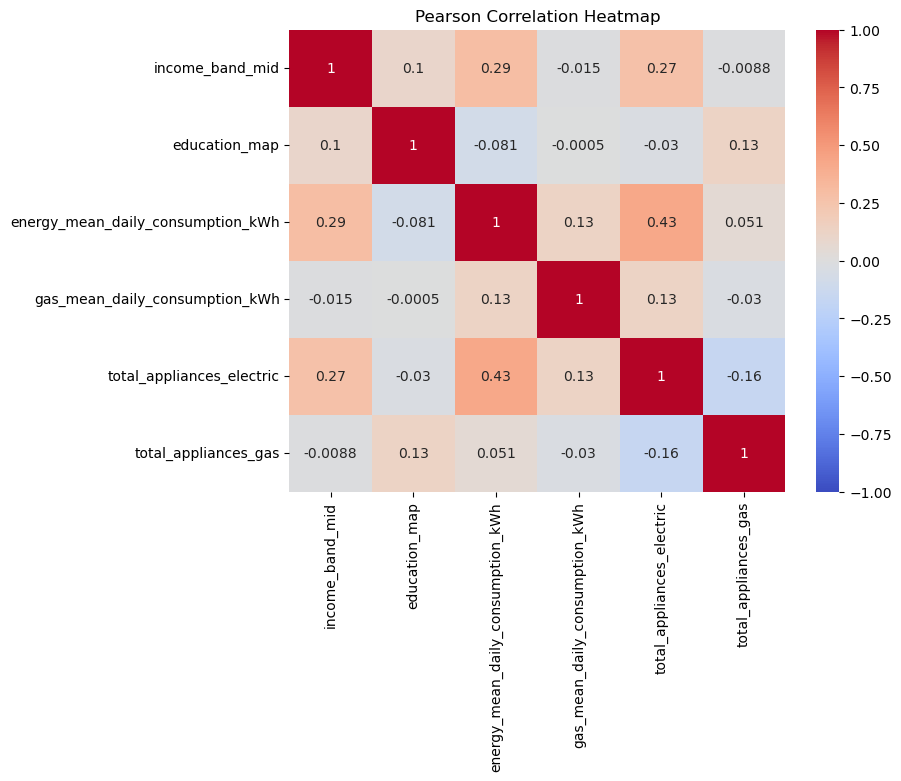

In [125]:
cols_of_interest = [
    "income_band_mid", 
    "education_map", 
    "energy_mean_daily_consumption_kWh", 
    "gas_mean_daily_consumption_kWh", 
    "total_appliances_electric",
    "total_appliances_gas"
]

subset_df = dataset_scaled[cols_of_interest].copy()

# 3. Compute the correlation matrix
corr_matrix = subset_df.corr(method='pearson')

# 4. Plot a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap")
plt.show()

         total_appliances_electric  total_appliances_gas  \
cluster                                                    
0                        29.322785              7.525316   
1                        25.364583              7.583333   

         energy_mean_daily_consumption_kWh  gas_mean_daily_consumption_kWh  \
cluster                                                                      
0                                 0.410345                        4.645287   
1                                 0.308386                        5.855872   

         income_band_mid  education_map  
cluster                                  
0               11.56962       7.848101  
1                4.43750       7.427083  


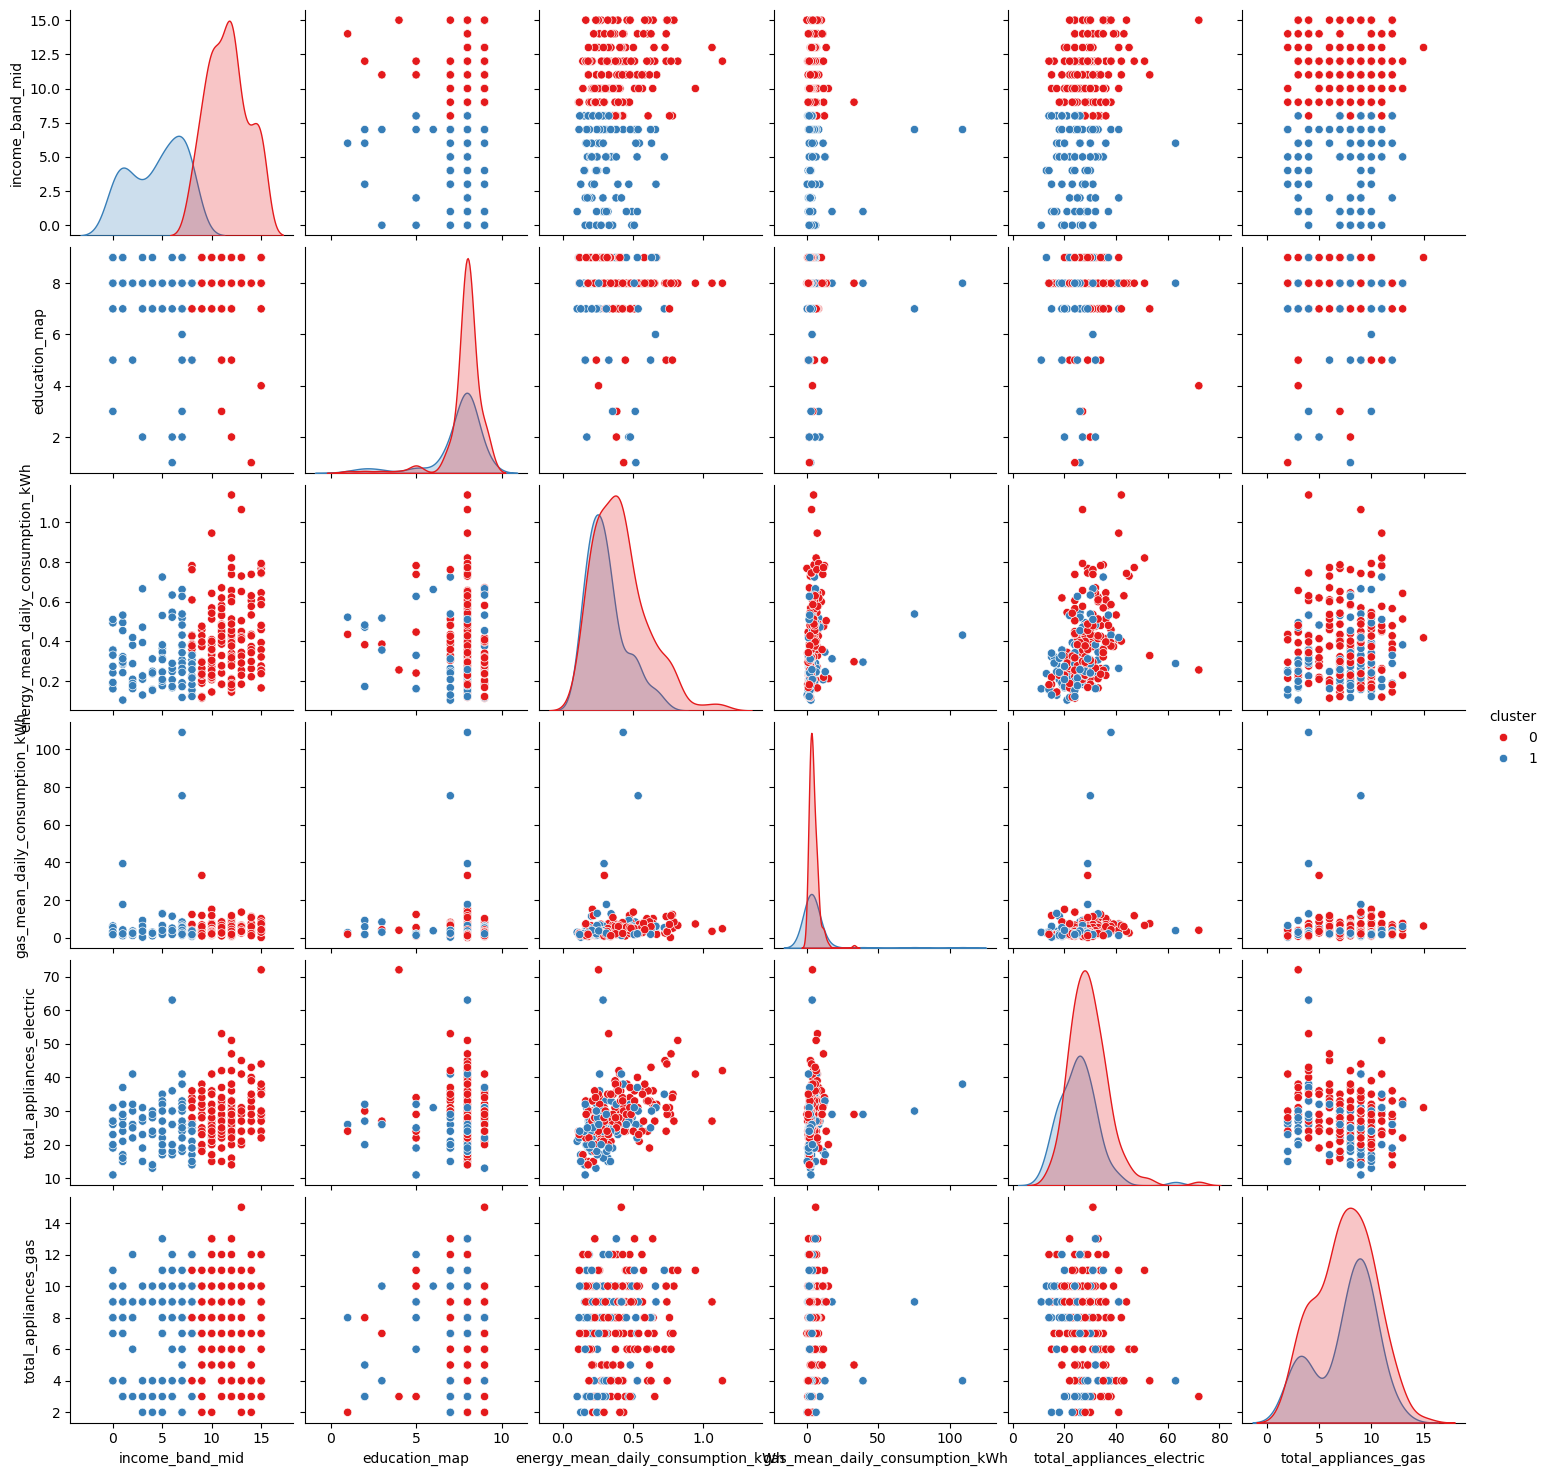

In [126]:
# Assign labels to the unscaled data
dataset_clustering["cluster"] = kmeans.labels_

# Analysis of mean values in cluster for better comparison
clustering_mean = dataset_clustering.groupby("cluster").mean()
print(clustering_mean.head())

# Pair plot
sns.pairplot(dataset_clustering, hue="cluster", 
             vars=["income_band_mid", "education_map", "energy_mean_daily_consumption_kWh",
                   "gas_mean_daily_consumption_kWh", "total_appliances_electric", "total_appliances_gas"],
                   palette="Set1")
plt.show()
